In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from forecast_combine.reconcile import ForecastReconciler

Importing plotly failed. Interactive plots will not work.


In [2]:
holiday_type = pd.read_excel('../data/holidays.xlsx', parse_dates=['date'], index_col='date')
holiday_type = pd.get_dummies(holiday_type['Type']).astype(int)
CIC_X = holiday_type.resample('B').last().fillna(0)

In [3]:
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')['NFA']

dateindex = pd.date_range(start=NFA.index[0], 
                             end=NFA.index[-1] + pd.Timedelta(days=365),
                            freq='B')
exogs = pd.DataFrame(index=dateindex)

exogs['trend'] = np.arange(len(exogs))
# Define seasonalities based on your original expressions
exogs['yearly_season'] = np.sin(2 * np.pi * exogs['trend'] / 260)  # Assuming 260 working days per year for yearly seasonality
exogs['monthly_season'] = np.sin(2 * np.pi * exogs['trend'] / 22)  # Assuming about 22 working days per month
exogs['weekly_season'] = np.sin(2 * np.pi * exogs['trend'] / 5)   # Assuming 5 working days per week
exogs['break'] = np.where(exogs.index > '2020-01-06', 1, 0)

NFA_X = exogs

In [4]:
# trained models for each autonomous factor
output_folder = '../model_output/'
model_names = ['CIC', 'NFA', 'SAB', 'Total_AF']
forecasters_d = {}
for model_name in model_names:
    with open(output_folder + model_name + '_forecast.pkl', 'rb') as f:
        forecasters_d[model_name] = pickle.load(f)    

# Hierarchical relationship matrix
S = pd.DataFrame(np.array([[1,-1,-1], [1,0,0], [0,1,0], [0,0,1]]), 
                 columns=['NFA', 'CIC', 'SAB',], 
                 index=['Total_AF', 'NFA', 'CIC', 'SAB'])

# Hiearchical reconciliation model
reconciler = ForecastReconciler(forecasters_d=forecasters_d, S = S)

In [7]:
pd.DataFrame(reconciled_preds)

,Total_AF,NFA,CIC,SAB
2022-02-21,8236.924805,33235.562211,-8380.616228,-16618.021178
2022-02-22,7581.187500,30589.696369,-7713.439723,-15295.069145
2022-02-23,7822.504395,31563.397459,-7958.966340,-15781.926724
2022-02-24,7633.765137,30801.844392,-7766.934566,-15401.144689
2022-02-25,7683.805386,31003.754188,-7817.847756,-15502.101046
2022-02-28,7571.190430,30549.358711,-7703.268256,-15274.900025
2022-03-01,7538.377930,30416.961984,-7669.883349,-15208.700705
2022-03-02,7483.039551,30193.674510,-7613.579604,-15097.055355
2022-03-03,7438.964355,30015.833394,-7568.735526,-15008.133513
2022-03-04,5713.338137,23053.021556,-5813.006121,-11526.677299


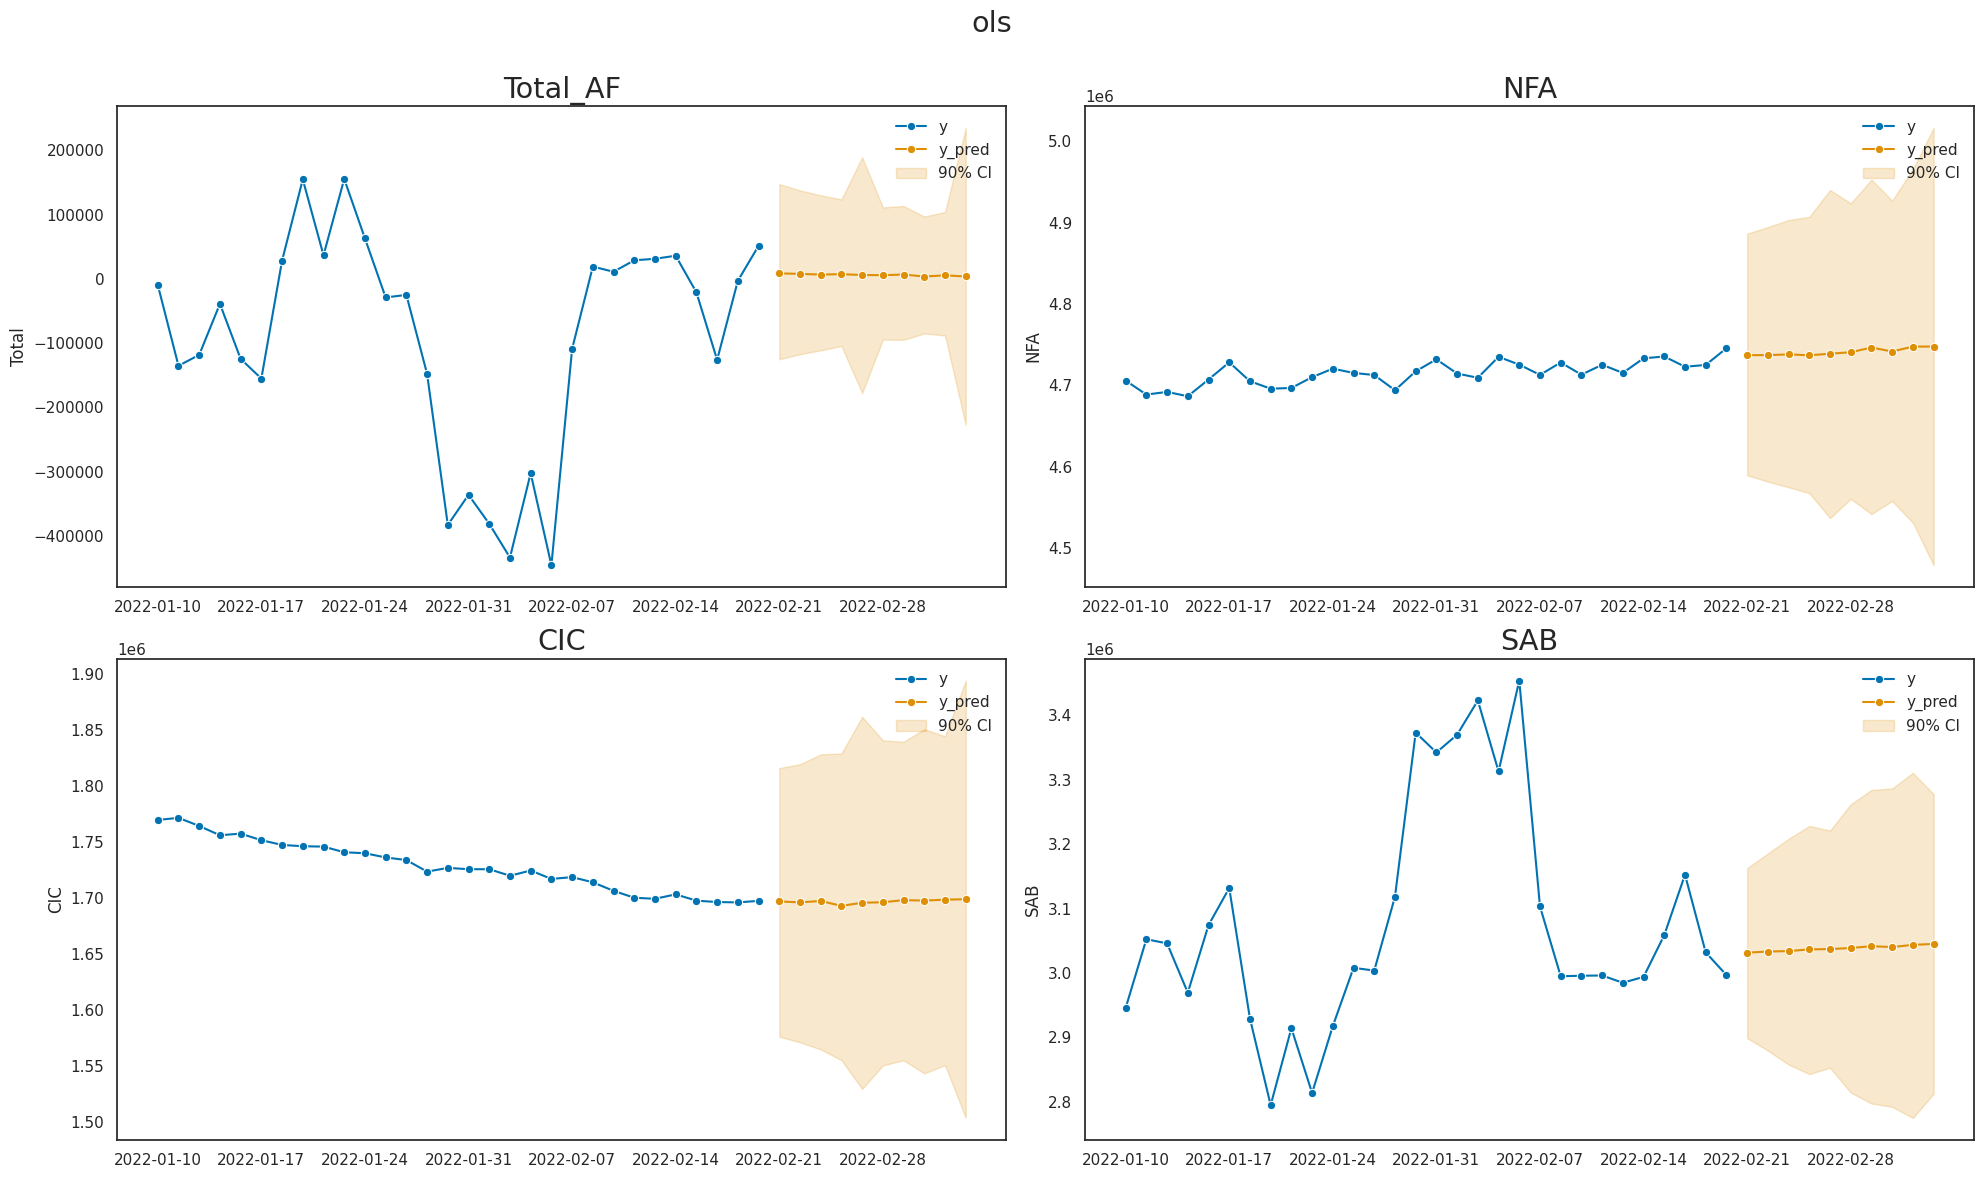

wls reconciliation method requires the forecasters prediction errors variance-covariance matrix ...


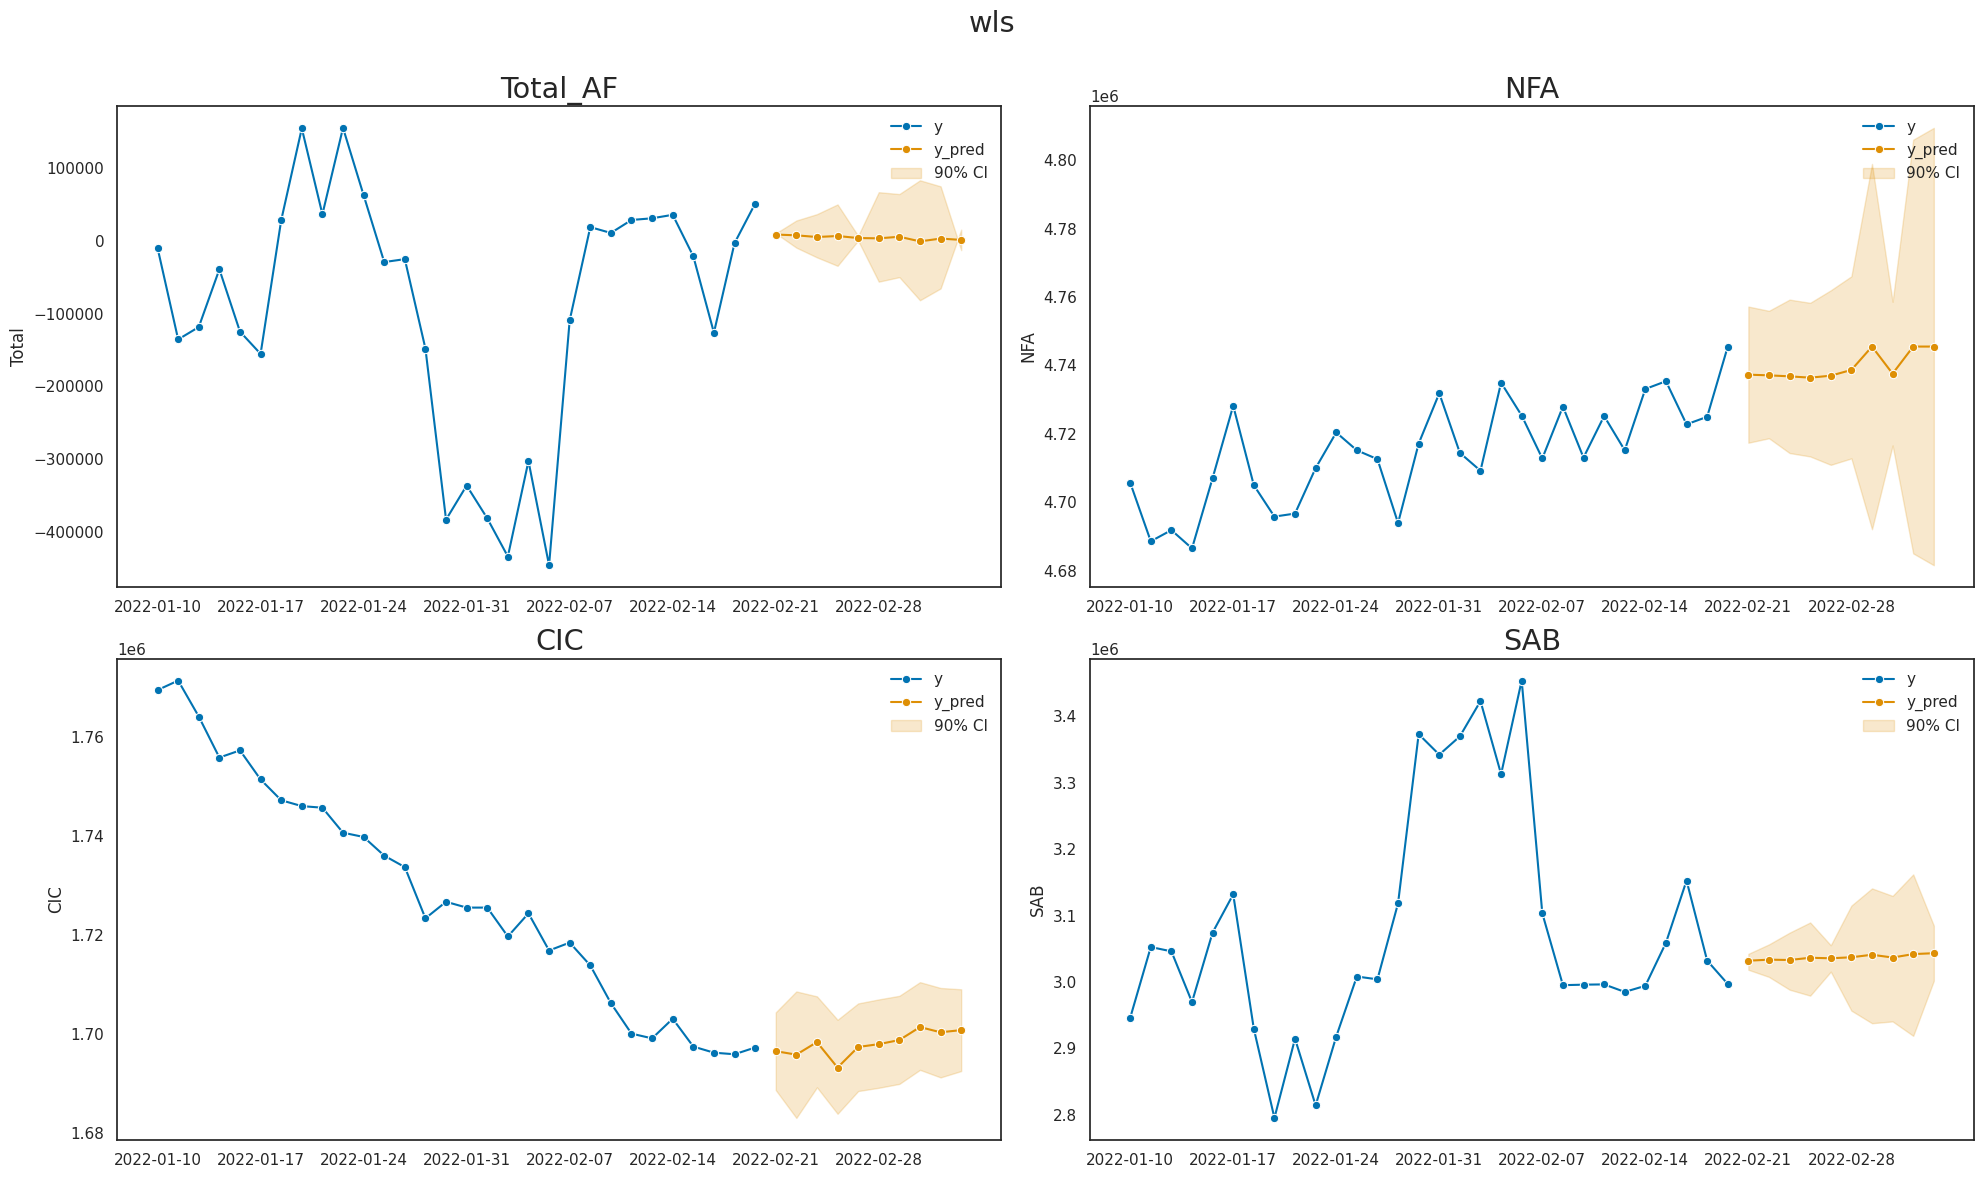

mint reconciliation method requires the forecasters prediction errors variance-covariance matrix ...


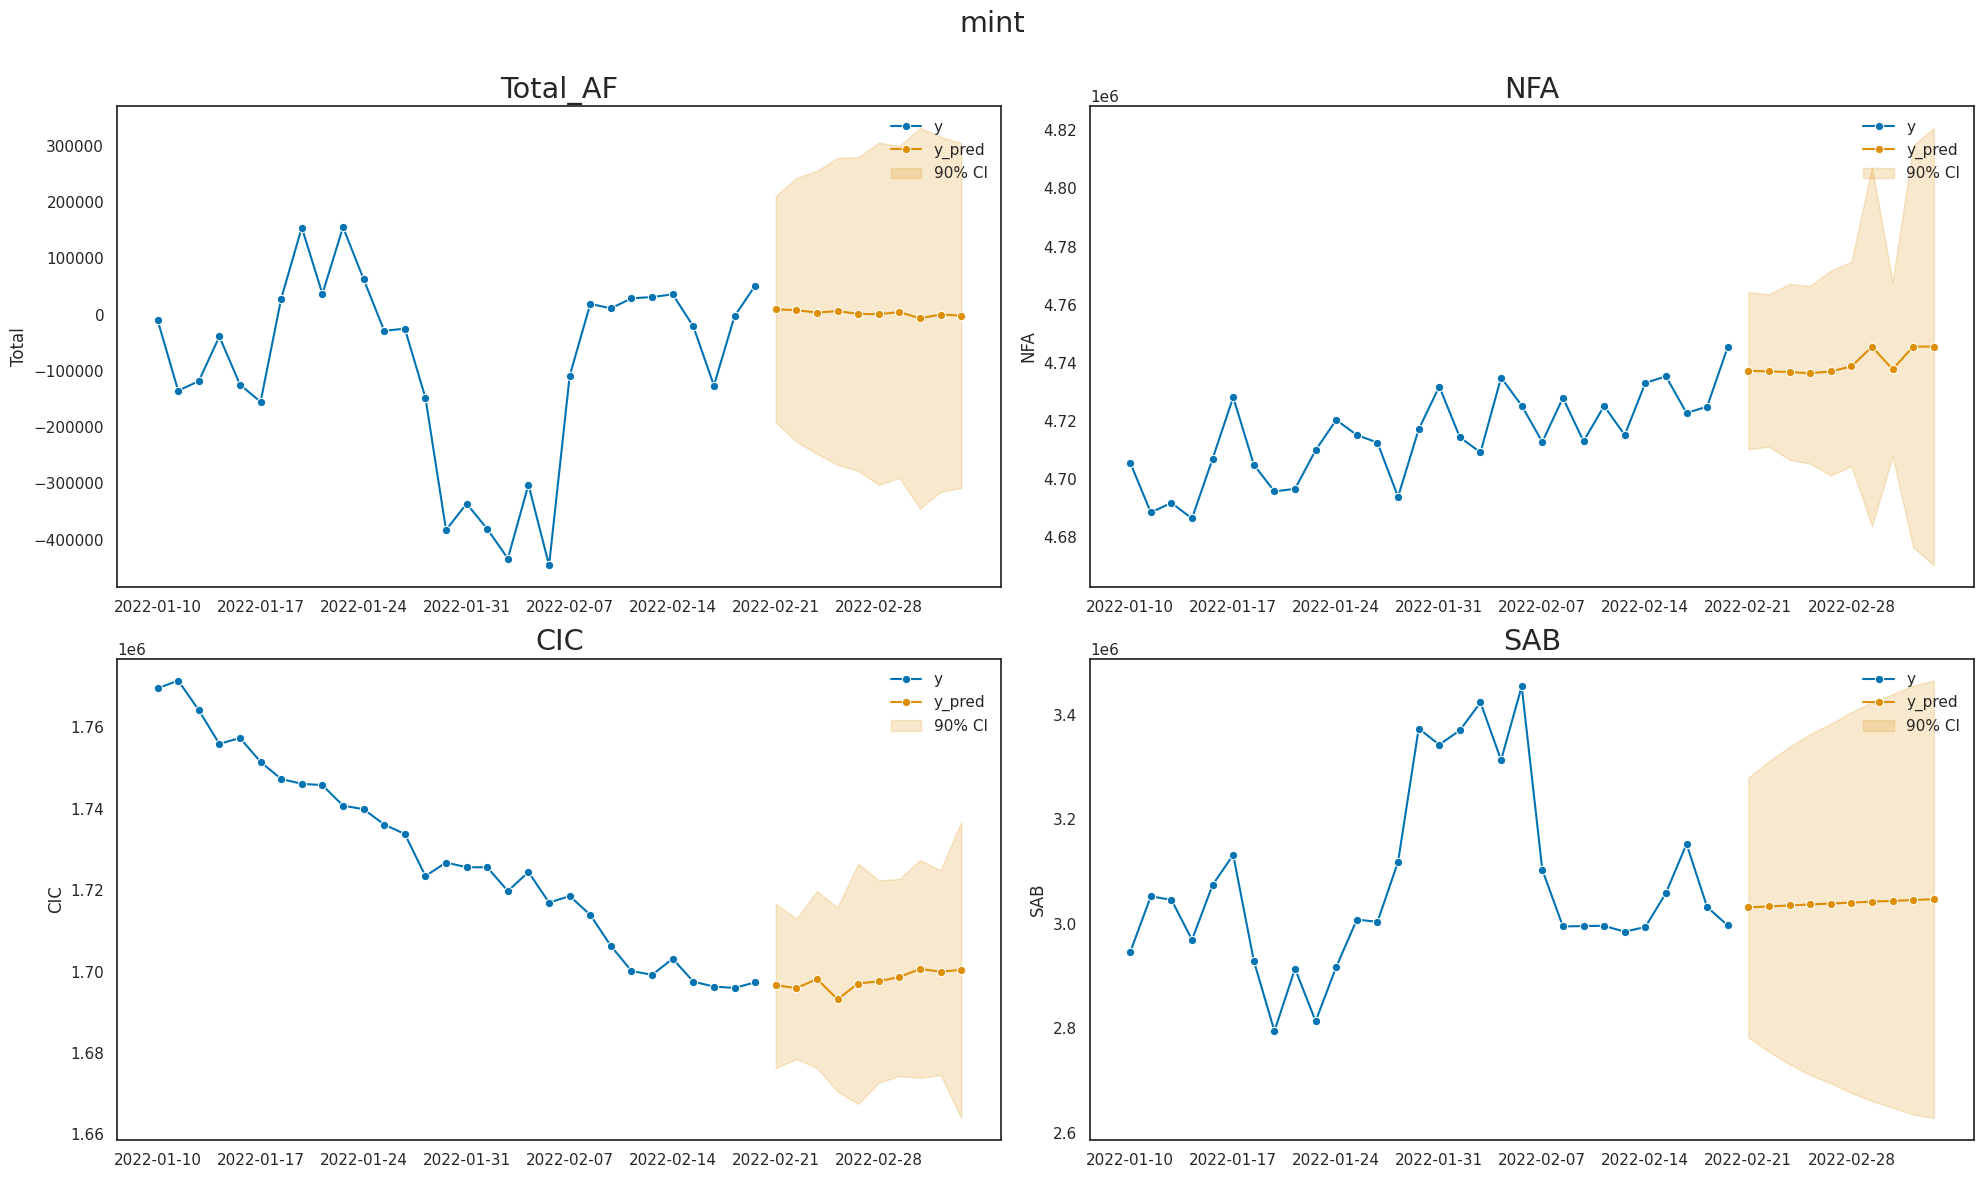

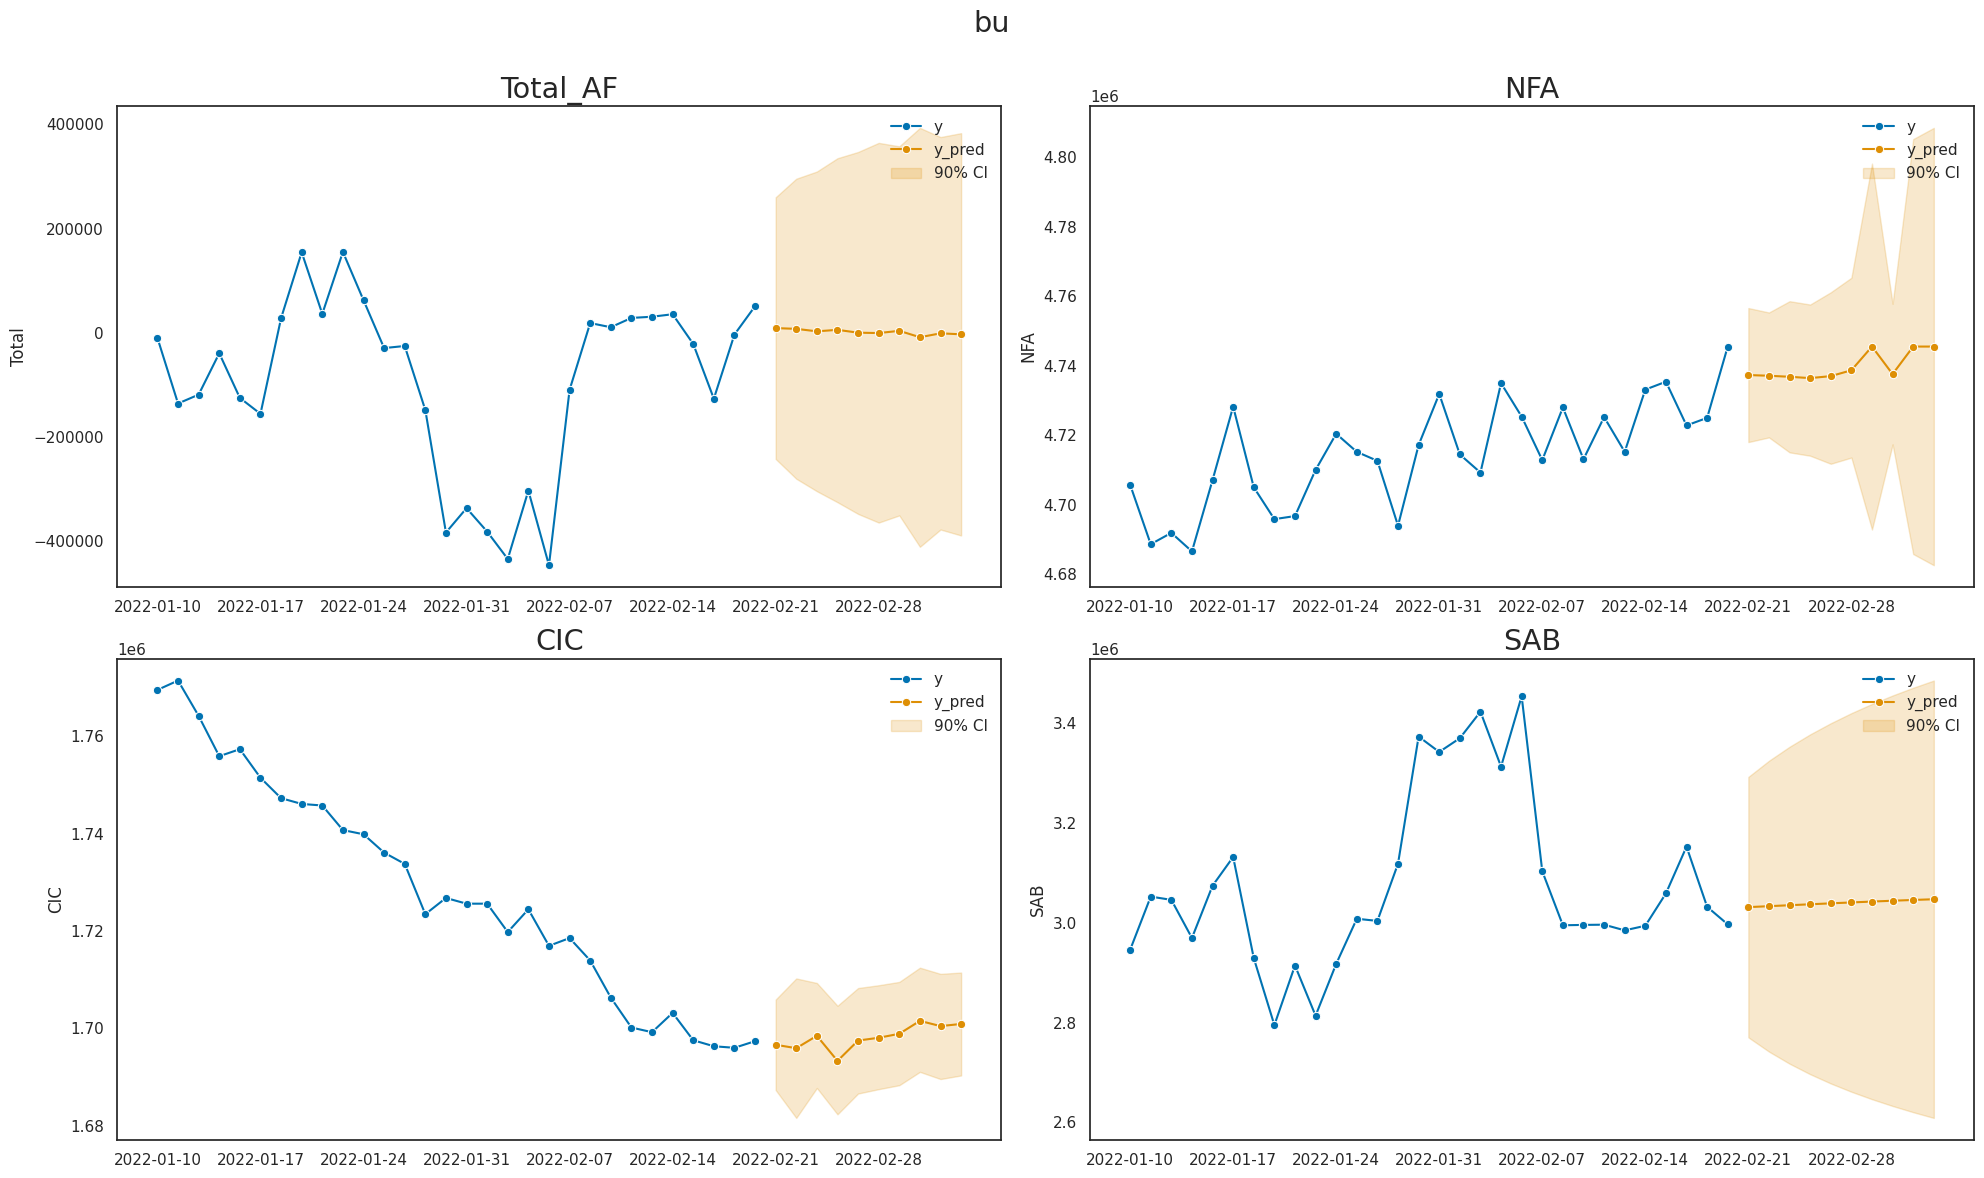

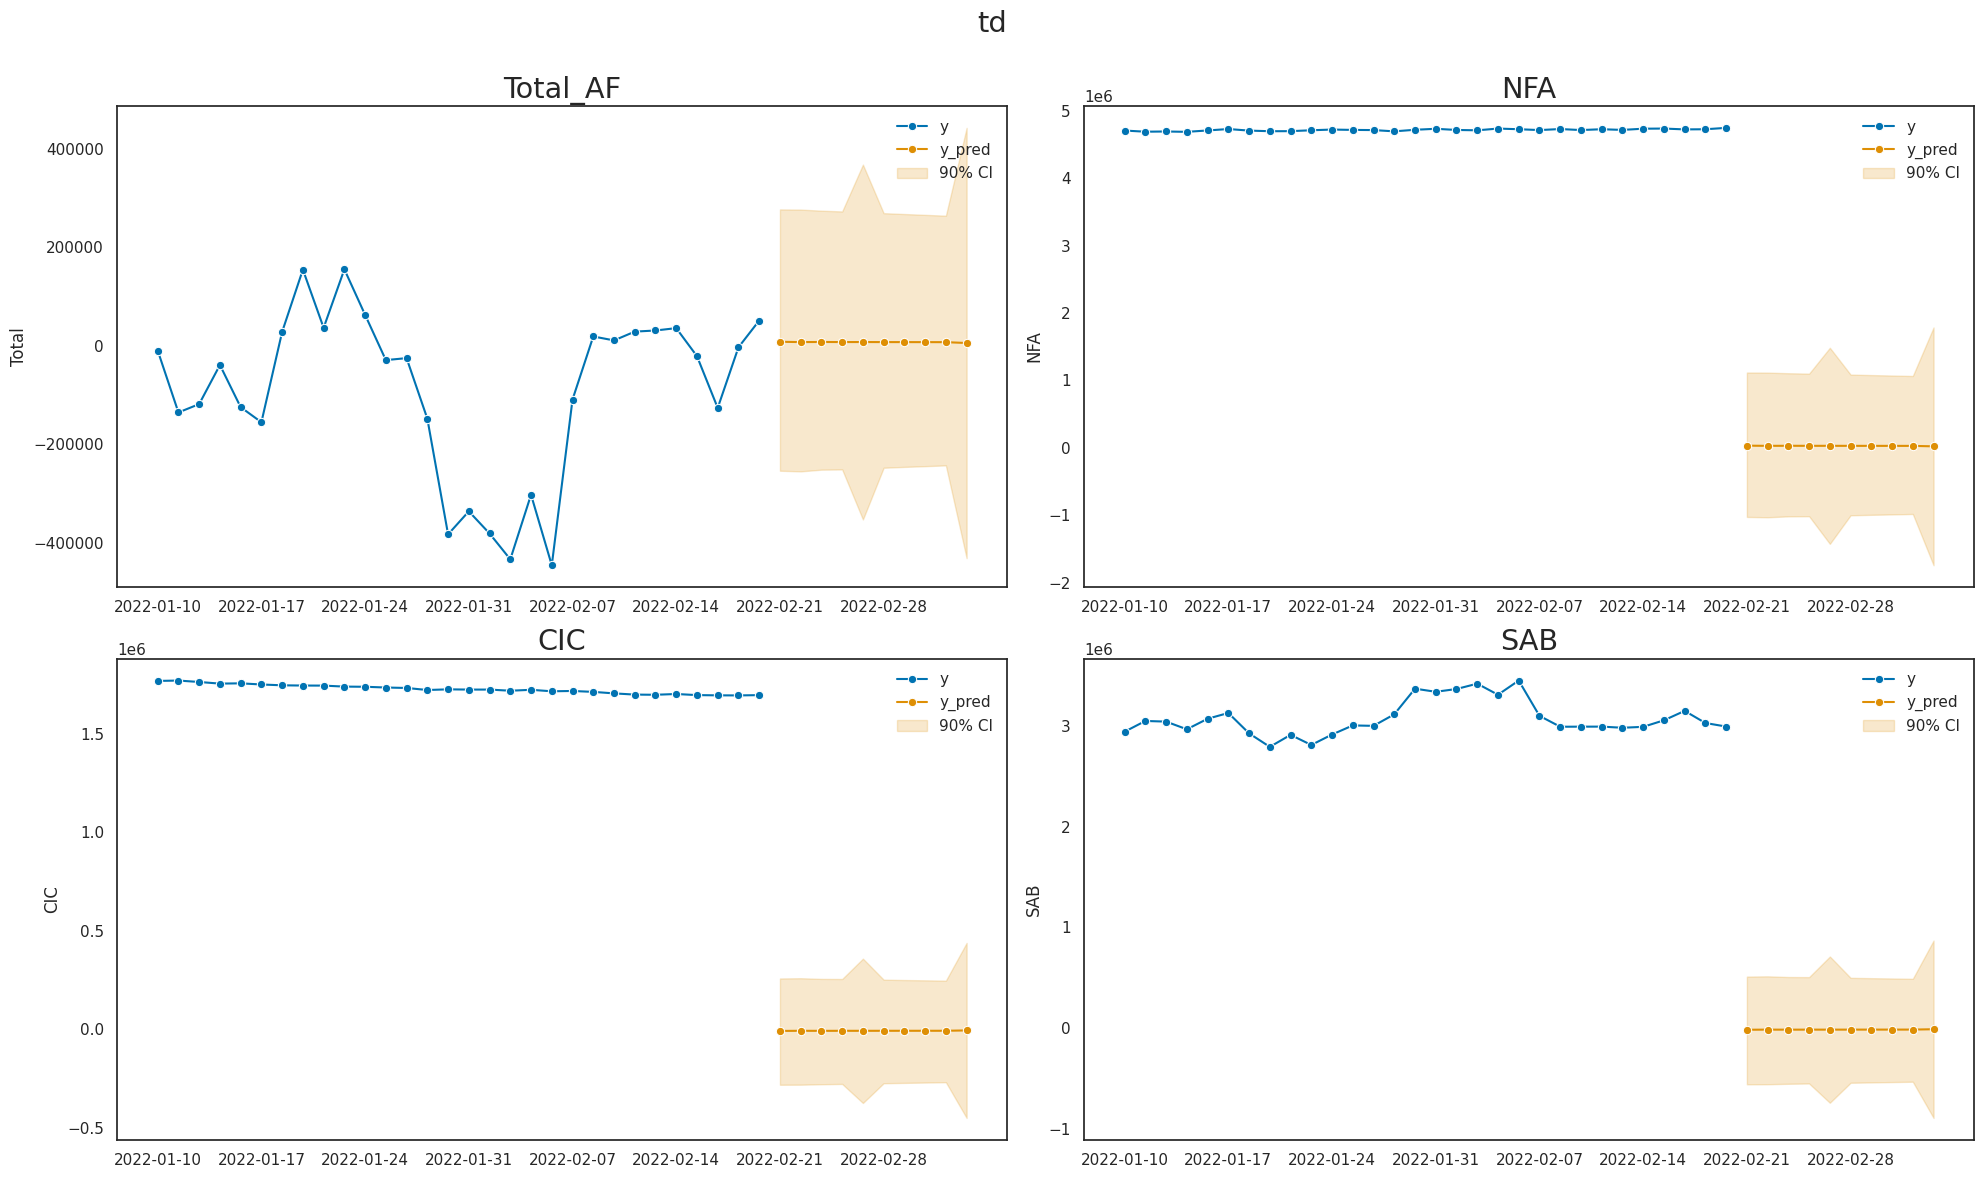

In [5]:
for m in ['ols', 'wls', 'mint', 'bu']:
    reconciled_preds, reconciled_intervals = reconciler.predict(X = {'NFA': NFA_X, 'CIC': CIC_X},
                                                                reconciliation_method = m)
    reconciler.plot_predict(reconciled_preds, reconciled_intervals, title = m)
    plt.show()